# Why Some Beers Spark Debate: A Short Walk Through Controversial Brews

Reload necessary functions

In [23]:
from importlib import reload
import src.utils.utils_functions
reload(src.utils.utils_functions)
from src.utils.utils_functions import *

Import Libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from src.utils.utils_functions import *

# Part 1 Understanding and treating the data

## Part 1.1 Data conversion

The first step in our analysis is to ensure all data is represented consistently across the project. This involves converting the original **.txt** files containing ratings and reviews into **.csv** format. Each file was examined carefully, the strings were stored into dictionaries representing key data fields. More details on the conversion process and methodology can be found in **data/TxtToCsv.ipynb**

The CSV files can be found on the following link: https://drive.google.com/drive/folders/1lcRRxlPpcyAcqJzanlwcyb5Vmip0s7_D?usp=sharing
(You will need to ask for permission to see the files)

## Part 1.2 Data exploration

With the data now in a consistent format, we begin exploring deeper the datasets to understand their links and features. We learn especially that some breweries, beers, users matches between the websites. Moreover, their might be duplicates within the datasets, with some users having multiple accounts. Breweries also have duplicates: i.e a single brewery in ratebeer can correspond to up to 3 breweries in advocate. The goal of this notebook was also to look at the percentage of Nan values for the ratings, and to understand the different variables. Further explanations can be found in **data/data_understanding.ipynb**.

Furthermore an other Jupyter Notebook explores Nan values in the dataset. It is mainly a secondary file that was used to evaluate the percentage of Nan in columns of a dataframe. In there we look at the min/max value of the different grades, where we noticed that both datasets not necessarily contain the same range for their grades. More information can be found in **data/data_cleaning.ipynb**.

Some rows contain NaN values in the datasets. Since certain parts of the analysis do not require every feature, we handle missing data filtering based on the requirements of each analysis section.

## Part 1.3 Dataset merging
To enhance the robustness of the analysis, we merge data from both RateBeer and BeerAdvocate. This approach increases the number of ratings per beer enabling a higher reliability and enhancing the controversiality analysis.

The aim is to have a general dataset for users, beers, breweries and ratings. For users, breweries, ratings each one contains a new id, the old id from both datasets except for ratings. It also contains the name, location and other information. If it is match we often make a choice from which dataset to use the information, for example as two breweries in advocate are a single in ratebeer we decided to take the name of the brewery from ratebeer. We filter out the matched informations as a single one.

For ratings we have every rating of both datasets, even the one matched twice. We decided to keep them both as we noticed that comments may differ in the grading and textual description. We added columns corresponding to the new beer, user and brewery id. Certain attributes where deleted as we assumed that we could recompute them again, or if need could reload the old files. Finally we gave an id to each rating, the dataset of origin as 'rb' or 'ad', and we added a column called matched if filled with a number contains the id of the rating it is matched with.

Further information can be found add **data/merge_into_onedataset.ipynb**. The transformed data can be found at the following link:
https://drive.google.com/drive/folders/1McQ7BU24mEsEqouulOPqrmtQJ47E6ZP8?usp=sharing
(You will need to ask for permission).


**Data Loading**

For the whole the next cell calls the different datasets and is used for the rest of the notebook.

In [3]:
root = Path(os.getcwd()).parent

# Files are located in Dataset folder
dataset_path = os.path.join(root,'Dataset')

FULL = "full"
FULL_PATH = os.path.join(dataset_path,FULL)

breweries_df = pd.read_csv(os.path.join(FULL_PATH, 'breweries.csv'))
beers_df = pd.read_csv(os.path.join(FULL_PATH, 'beers.csv'))
users_df = pd.read_csv(os.path.join(FULL_PATH, 'users.csv'))
ratings_df = pd.read_csv(os.path.join(FULL_PATH,'ratings.csv'))
sentiment_df = pd.read_csv(os.path.join(FULL_PATH,'beer_reviews_with_sent.csv'))
ratings_with_sent_df = ratings_df.join(sentiment_df.set_index('id'), on='id')
del sentiment_df

C:\Users\nouxy\AppData\Local\Temp\ipykernel_11928\1049982649.py:10: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_df = pd.read_csv(os.path.join(FULL_PATH, 'beers.csv'))
C:\Users\nouxy\AppData\Local\Temp\ipykernel_11928\1049982649.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv(os.path.join(FULL_PATH, 'users.csv'))


**Grade distribution**

In [16]:
compute_stastics(ratings_df) # FAUDRAIT MODIFIER CETTE 
# FONCTION POUR QU'ELLE PRINT AVEC DES RETOUR à LA LINE

{'ad': {'aroma': {'min': 1.0, 'max': 5.0, 'median': 4.0, 'resolution': 0.25}, 'palate': {'min': 1.0, 'max': 5.0, 'median': 4.0, 'resolution': 0.25}, 'taste': {'min': 1.0, 'max': 5.0, 'median': 4.0, 'resolution': 0.25}, 'overall': {'min': 1.0, 'max': 5.0, 'median': 4.0, 'resolution': 0.25}, 'rating': {'min': 1.0, 'max': 5.0, 'median': 4.0, 'resolution': 0.009999999999999787}}, 'rb': {'aroma': {'min': 1.0, 'max': 10.0, 'median': 7.0, 'resolution': 1.0}, 'palate': {'min': 1.0, 'max': 5.0, 'median': 3.0, 'resolution': 1.0}, 'taste': {'min': 1.0, 'max': 10.0, 'median': 7.0, 'resolution': 1.0}, 'overall': {'min': 1.0, 'max': 20.0, 'median': 14.0, 'resolution': 1.0}, 'rating': {'min': 0.5, 'max': 5.0, 'median': 3.4, 'resolution': 0.09999999999999964}}}


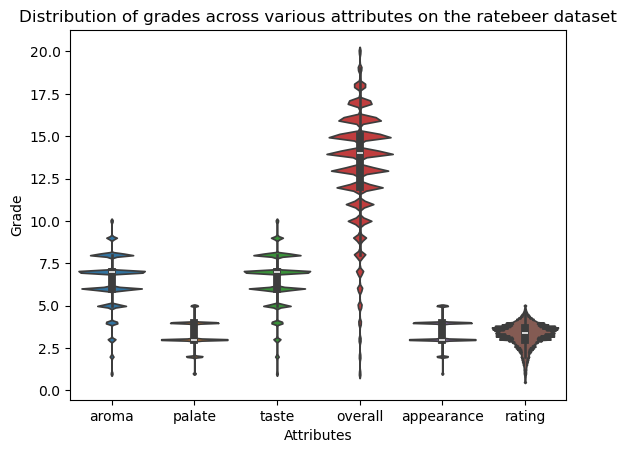

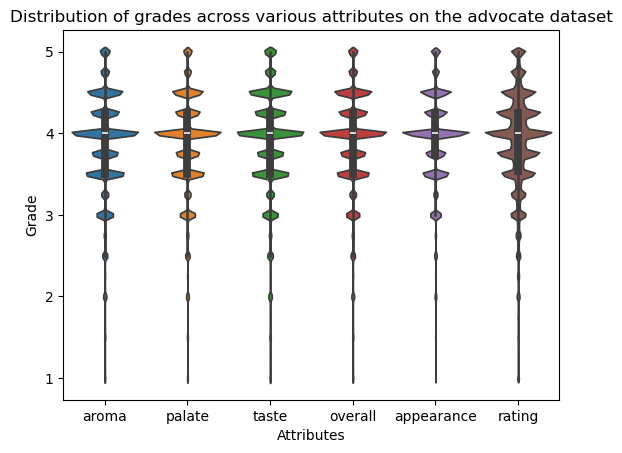

In [14]:
plot_var_distrib_violin_grades(ratings_df=ratings_df)

**Grade transformation**
We notice during the data cleaning that grades do not have the same range and resolution on both webistes. 

BeerAdvocate allow the user to rate five attributes (aroma, palate, taste, appearance, overall) on a scale of 1 to 5 with a resolution of 0.25, while RateBeer allow the user to rate aroma and taste between 1 and 10, appearance palate between 1 and 5 and overall between 1 and 20, all with a resolution of 1.

To perform our analysis, we must transform the grades to have the same scale between the two dataset. We decided to set the grade between 1 and 5 as most attributes are graded with this range. This is done by converting RateBeer scales according to the following formula : 

$$ \frac{\text{grade} - \text{min}}{\text{max} - \text{min}} \cdot 4 + 1 $$
- with $\text{max}$ the largest grade one can give to a given attribute.
- with $\text{min}$ the lowest grade one can give to a given attribute.

In [17]:
ratings_df = recompute_grade(ratings_df, min_grade_value = 1, max_grade_value = 5, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'])
# TO DO ELSEWHERE : ratings_df_with_sent = recompute_grade(ratings_with_sent_df, min_grade_value = 1, max_grade_value = 5, attributes_of_interest = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating','sentiment_bert'])

**Grade distribution after rescaling**

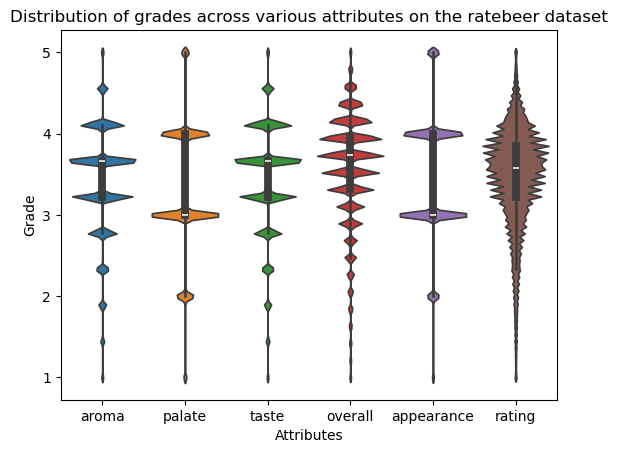

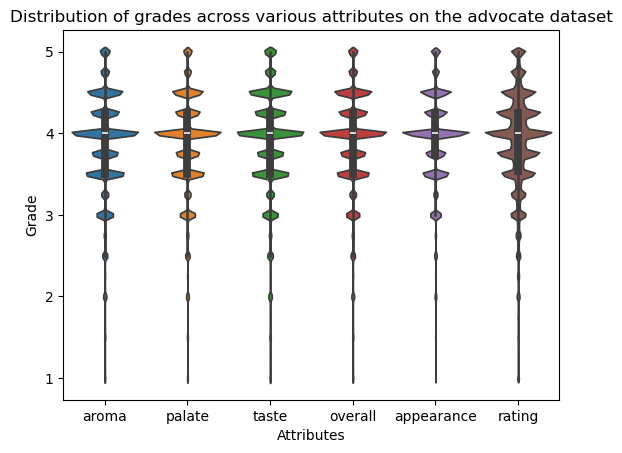

In [18]:
plot_var_distrib_violin_grades(ratings_df=ratings_df)

As we can see, it results in attributes having different resolutions. This might be a problem when computing some metrics to define the controversiality and comparing between attributes. This will be discussed further.

# Part 2 Exploring the definition of controversiality

This part aims to determine and label which beers are controversial and which are universal. To do this, we explore different aspects defining the controversiality of a beer. 

What does controversial mean : "subject of intense public argument, disagreement, or disapproval" [1]. As described, this depends on the opinions of the people. As a result, this analysis only depends on the fields the users can fulfill, namely, the different ratings : appearance, aroma, palate, taste, overall, and the textual reviews

We first try to label the beers using the grades provided by the user, later we will try to add the sentiment analysis and observe if it helps in separating the beers.

## Part 2.1 Ratings and reviews filtering

As mentioned earlier, controversiality depends on disagreement in opinions. Beers with few ratings are more likely to show high variability (e.g. two opposing opinions). To ensure reliable insights and meaningful analysis, we exclude beers with fewer number of ratings or reviews than a specified threshold. (((((((((((Later, we might apply a weighting factor based on rating count to further refine the controversiality analysis, according more importance to more rated beers.)))))))))))

Let's try to find a reasonable threshold.



In [25]:
test_threshold_filtering(ratings_df)

Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 5 valid ratings : 72.37 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 10 valid ratings : 68.65 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 15 valid ratings : 65.76 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 20 valid ratings : 63.35 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 25 valid ratings : 61.26 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 30 valid ratings : 59.38 %
Percentage of ratings remaining after dropping rows with nan values and rating for which beer has less than 35 valid ratings : 57.70 %
Percentage of ratings remaining after dropping rows with

The choice of the threhsold is : x

In [27]:
beer_ratings, breweries_df, beers_df, users_df = filter_ratings_new(ratings_df, beers_df, breweries_df,users_df, threshold=10, attributes=['appearance', 'aroma', 'palate', 'taste', 'overall'])

Pourcentage of ratings remaining after dropping rows with nan values in selected attributes: 76.65 %
Pourcentage of ratings remaining after dropping rating for which beer has too few valid ratings : 68.65 %
Pourcentage of beers remaining after dropping rating for which a beer has too few valid ratings : 21.98 %
Pourcentage of breweries remaining after dropping rating for which a beer has too few valid ratings : 38.30 %
Pourcentage of users remaining after dropping rating for which a beer has too few valid ratings : 73.13 %
